In [1]:
import os
import sys

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
    
import torchx

In [2]:
from FastSCNN import AudiDataset, FastSCNN

In [3]:
params = torchx.params.Parameters("params.yml")

In [4]:
num_classes = 2 if params.single_class else len(AudiDataset.classes)+1

In [5]:
model = FastSCNN(image_height   = params.crop_height,
                 image_width    = params.crop_width,
                 image_channels = 3,
                 num_classes    = num_classes).eval()

In [6]:
model.load("checkpoints/latest_half_scale_single_class_fastscnn.pt")

In [7]:
test_dataset = AudiDataset(params.crop_height, params.crop_width, params.resize_scale, mode="test", single_class = params.single_class)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size  = 1,
    num_workers = 4,
    shuffle     = True
)
dataloader = iter(test_dataloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


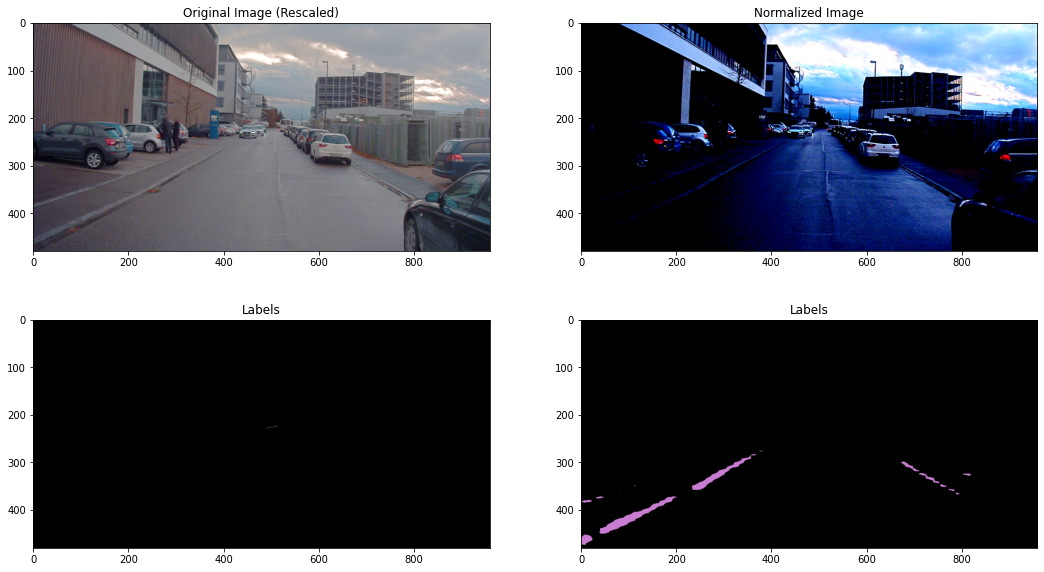

In [17]:
image, label = next(dataloader)

with torch.no_grad():
    output = model(image)
    
fig, ax = plt.subplots(2, 2, figsize=(18, 10))

ax[0, 0].imshow(np.moveaxis(np.array(test_dataset.denormalize(image[0])), 0, -1))
ax[0, 0].set_title("Original Image (Rescaled)")

ax[0, 1].imshow(np.moveaxis(image[0].detach().numpy(), 0, -1))
ax[0, 1].set_title("Normalized Image")

ax[1, 0].imshow(torchx.utils.decode_array(label[0].detach().numpy(), test_dataset.class_list))
ax[1, 0].set_title("Labels")

ax[1, 1].imshow(torchx.utils.decode_array(output[0].argmax(axis=0), test_dataset.class_list))
ax[1, 1].set_title("Labels")

plt.show()

## Testing Accuracy

In [13]:
def compute_hist(a, b, n):
	k = (a >= 0) & (a < n)
	return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)

iou_per_class = lambda hist: (np.diag(hist) + 1e-5) / (hist.sum(1) + hist.sum(0) - np.diag(hist) + 1e-5)

def run_test():

    with torch.no_grad(), tqdm(total=len(test_dataloader), position=0, leave=False) as val_progress:
        model.eval()
    
        val_progress.set_description('testing')
        
        precisions = []
        hist = np.zeros((num_classes, num_classes))

        for i, (data, label) in enumerate(test_dataloader):
                            
            output = model(data).squeeze()
            output = reverse_one_hot(output)
            output = np.array(output)

            label = label.squeeze()
            label = np.array(label)

            precisions.append(np.sum(output == label) / np.prod(label.shape))
            hist += compute_hist(output.flatten(), label.flatten(), num_classes)
            
            val_progress.set_postfix(precision='%.6f' % np.mean(precisions))
            val_progress.update()
        
        precision = np.mean(precisions)
        iou = iou_per_class(hist)[:-1]
        miou = np.mean(iou)
    
    return precision, miou, iou

In [14]:
precision, miou, iou = run_test()

In [15]:
precision

0.9874482929218613

In [16]:
miou

0.5797625302831695

In [17]:
iou

array([0.98782668, 0.47653893, 0.40126869, 0.45341582])

Achieved precision of 0.9874482929218613

Achieved miou of 0.5797625302831695

iou per class: [0.98782668, 0.47653893, 0.40126869, 0.45341582]

## Timing Results

In [34]:
img = torch.randn(
    1,
    3,
    int(params.crop_height * params.resize_scale),
    int(params.crop_width * params.resize_scale),
)

In [13]:
%%timeit

with torch.no_grad():
    label = model(image)

77.1 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
